# <font color='navy'> <b> Riadenie simulácie pomocou *pyelmer* </b></font>

## <font color='teal'> <b> Priklad 2. </b></font>

Dve gule čiastočne ponorené v oleji. Upravené a doplnené súbory **\*.yml** pre generovanie parametrov simulácie.

### <font color='purple'> <b> Vytvorenie simulačného modelu </b></font>

In [3]:
# reset prostredia, pri opakovanom spusteni generuje zle vysledky
%reset -sf 

import gmsh
from utils.lib2d import *

gmsh.initialize()           # inicializacia a zrusenie vypisov
gmsh.option.setNumber("General.Terminal", 0) 
gmsh.clear()                # reset gmsh
Model.items = {}            # inicializacia slovnika komponentov prostredia

pp = [                     
    Point(0,0,   'P1'),     # defincia prostredia pre ulohu - body obrysu
    Point(0,5,   'P2'),
    Point(0,10,  'P3'),
    Point(10,10, 'P4'),
    Point(10,5,  'P5'),
    Point(10,0,  'P6'),
]
                             # vyvorenie krivky obrysu
P = PolyLine(pp, closed=True, name = 'PL') 

E1 = Circle(2.5, 5, 1, 'E1')       # vytvorenie kriviek elektrod
E2 = Circle(7.5, 5, 1, 'E2') 
                           
L1 = Line(NM('P2'), E1.w,    'L1') # spojovacie usecky medzi oblastami
L2 = Line(E1.e,     E2.w,    'L2')
L3 = Line(E2.e,    NM('P5'), 'L3')

# vytvorenie hranic prostredia - olej
LP1 = Loop([NM('PL-0'),  L1,   E1.sw,
            E1.se,       L2,   E2.sw,
            E2.se,       L3,   NM('PL-4'),
            NM('PL-5')   ])
# vzduch
LP2 = Loop([NM('PL-1'),  NM('PL-2'),  NM('PL-3'),
            L3,          E2.ne,       E2.nw,
            L2,          E1.ne,       E1.nw,
            L1           ])

# vytvorenie fyzickych oblasti simulacneho modelu
ps1    = PlaneSurface([LP1])
ps_oil = PhysicalSurface(ps1, "Olej")

ps2    = PlaneSurface([LP2])
ps_air = PhysicalSurface(ps2, "Vzduch")

pl_e1  = PhysicalLine(E1, "Lava elektroda") 
pl_e2  = PhysicalLine(E2, "Prava elektroda") 

pl_bound = PhysicalLine(P, "Okraj") 

gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)                   # vygenerovanie 2D mriezky 

gmsh.write("./sim_02/lib2d_02.vtk")           # zapis do suborov
gmsh.write("./sim_02/lib2d_02.msh")
gmsh.write("./sim_02/lib2d_02.geo_unrolled")

gmsh.fltk.run()                              # kontrolne zobrazenie v gmsh
gmsh.finalize()

In [4]:
# vygenerovanie popisu oblasti
from cm.utils import *

s = Plot(P) + Plot(E1) + Plot(E2) + Plot(L1) +  Plot(L2)  +  Plot(L3)
cm_compile('./img/obr_0020', s, grid=False, dpi=600, dx=10, dy=10)   
cm_show('./img/obr_0020.png', width=500)

### <font color='purple'> <b> Skript pre riadenie simulacie </b></font>

Doplnené konštanty, materiály a upravené generovanie rovníc

In [5]:
import os
import gmsh
from pyelmer import elmer, post
from pyelmer import execute

sim = elmer.load_simulation("2D_steady", "./sim_02/my_simulations.yml")
sim.constants.update({"Permittivity of Vacuum": "8.8542e-12"})
sim.constants.update({"Gravity(4)": "0 -1 0 9.82"})
sim.constants.update({"Boltzmann Constant": "1.3807e-23"})
sim.constants.update({"Unit Charge": "1.602e-19"})
sim.constants.update({"Stefan Boltzmann": "5.67e-08"})

# materials
air = elmer.load_material("air", sim, "./sim_02/my_materials.yml")
oil = elmer.load_material("oil", sim, "./sim_02/my_materials.yml")

# solver
solver_electrostatic = elmer.load_solver("Electrostatics", sim, r"./sim_02/my_solvers.yml")
solver_electrostatic.data.update({"Potential Difference": "1.0"})

# equation
eqn = elmer.Equation(sim, "main", [solver_electrostatic])

# bodies - physical surface
bdy_air = elmer.Body(sim, "Vzduch", [ps_air])   # 
bdy_air.material = air
bdy_air.equation = eqn

bdy_oil = elmer.Body(sim, "Oil", [ps_oil])      
bdy_oil.material = oil
bdy_oil.equation = eqn

# boundaries - physical lines
bndry_m1 = elmer.Boundary(sim, "Elektroda 1", [pl_e1])
bndry_m1.data.update({"Potential": "100.0"})

bndry_m2 = elmer.Boundary(sim, "Elektroda 2", [pl_e2])
bndry_m2.data.update({"Potential": "-100.0"})

bndry_airbox = elmer.Boundary(sim, "FarField", [pl_bound])
bndry_airbox.data.update({"Electric Infinity BC": "True"})

sim.write_startinfo('./sim_02/')
sim.write_sif('./sim_02/')

Wrote sif-file.


### <font color='purple'> <b> Spustenie simulácie a zobrazenie vysledkov </b></font>

In [6]:
execute.run_elmer_grid('./sim_02/', "lib2d_02.msh")
execute.run_elmer_solver('./sim_02/')

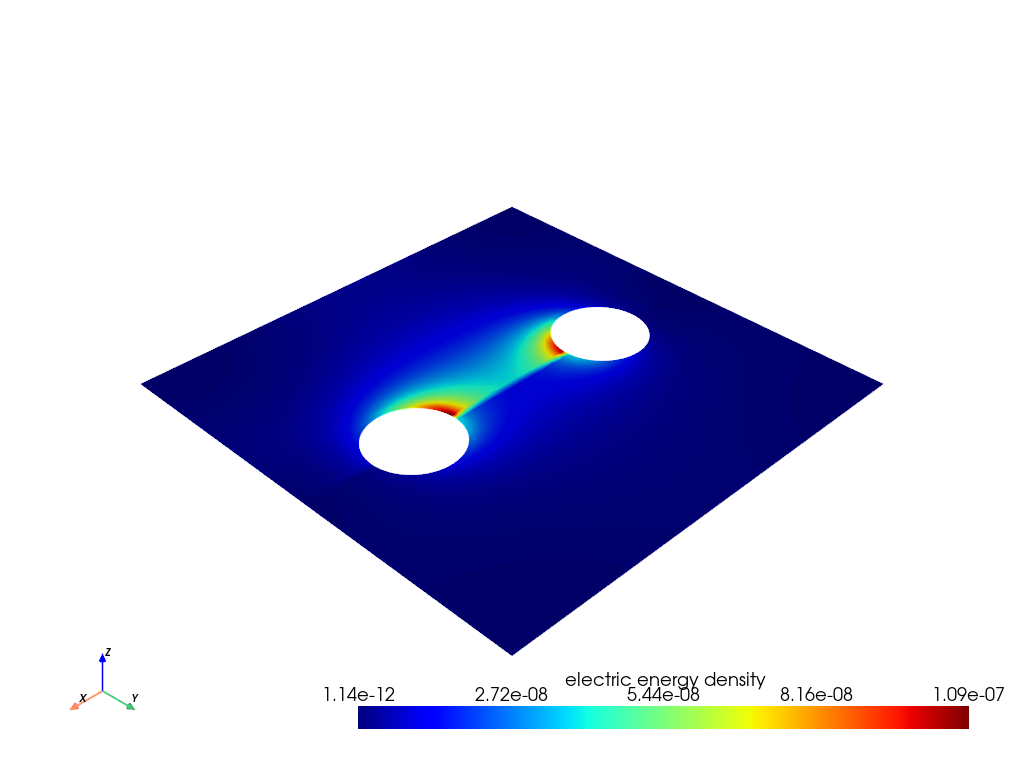

UnstructuredGrid (0x7fe7c82cb220)
  N Cells:    22730
  N Points:   11364
  X Bounds:   0.000e+00, 1.000e+01
  Y Bounds:   0.000e+00, 1.000e+01
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   5

In [7]:
import pyvista as pv
pv.set_jupyter_backend('static')
data = pv.read('./sim_02/case_t0002.vtu')
data.plot(scalars="electric energy density", cmap='jet')
data